In [58]:
import os
import cv2 as cv
import torch
from data_utils.utils import *
from modules.split_modules import SplitModel
from merge.heuristics import *

TRAIN_ERROR_DIR = '/Users/longhoang/Developer/table-reg/code/deep-split-merge-scitsr/merge/error/train'
TRAIN_DATA_DIR = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train/train'
CHUNK_JSON_LABEL = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/chunk_label.json'
MODEL_WEIGHT = '/Users/longhoang/Developer/table-reg/pretrain-models/split-merge/split_v2.pth'

IMG_DIR = os.path.join(TRAIN_DATA_DIR, 'img')


`TODO:`
- Image '1705.09436v1.1' has wrong Merge label

# Loading Split pretrained model

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SplitModel(3)
model = torch.nn.DataParallel(model).to(device)

if device == 'cuda':
    model.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    model.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

model.eval()
device

'cpu'

In [60]:
merge_labels = load_json(os.path.join(TRAIN_DATA_DIR, 'label/merge_label.json'))
print(f'Got {len(merge_labels)} merge labels')

chunk_labels = load_json(CHUNK_JSON_LABEL)
print(f'Got {len(chunk_labels)} chunk (OCR) labels')

Got 10000 merge labels
Got 11971 chunk (OCR) labels


# Error analysis

## `Case 1:` Table with single row or column

In [61]:
single_row_col_img_names = load_json(os.path.join(TRAIN_ERROR_DIR, 'single.json'))
single_row_col_img_names

['1612.02275v4.12',
 '1612.02590v3.7',
 '1509.00910v1.1',
 '1705.09436v1.1',
 '1805.05769v1.4',
 '1612.02590v3.9',
 '1805.05769v1.6',
 '1704.03895v1.6']

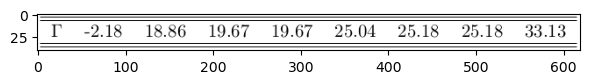

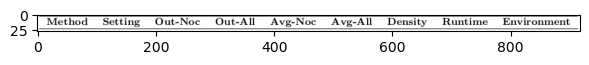

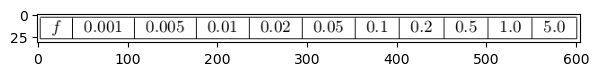

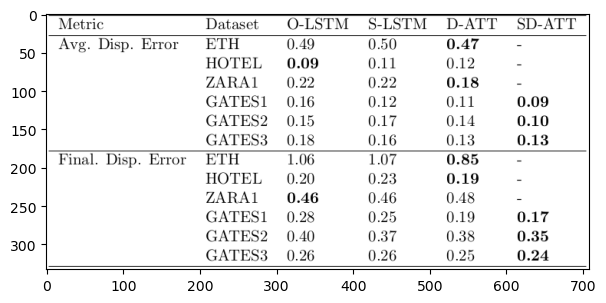

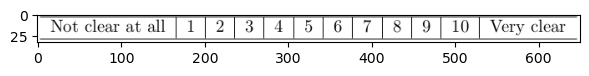

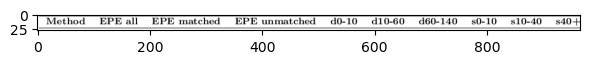

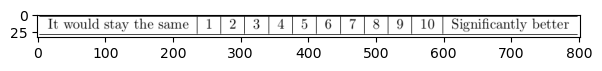

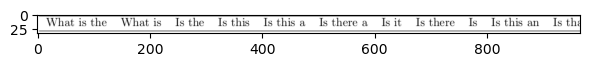

In [62]:
single_row_col_paths = [os.path.join(IMG_DIR, img_name + '.png') for img_name in single_row_col_img_names]
single_row_col_imgs = [load_image(img_path) for img_path in single_row_col_paths]
for img in single_row_col_imgs:
    view_imgs([img])

Path: /Users/longhoang/Developer/table-reg/data/scitsr-split-train/train/img/1612.02590v3.7.png


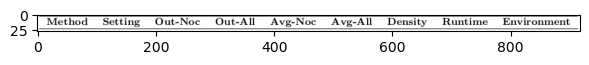

In [63]:
ID = 1
img, path, img_name = single_row_col_imgs[ID], single_row_col_paths[ID], single_row_col_img_names[ID]
print('Path:', path)
view_imgs([img])

In [64]:
r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
print('* Split ground truth:')
print(f'  Row vector of shape {r_gt.shape}, Col vector of shape {c_gt.shape}')
print('* Merge ground truth:')
print(f'  Merge right matrix of shape {R_gt.shape}, Merge down matrix of shape {D_gt.shape}')

* Split ground truth:
  Row vector of shape (28,), Col vector of shape (918,)
* Merge ground truth:
  Merge right matrix of shape (1, 8), Merge down matrix of shape (0,)


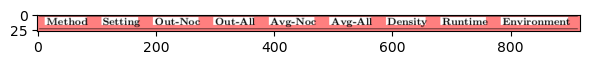

In [65]:
vis_split(img, r_gt, c_gt, 'red')

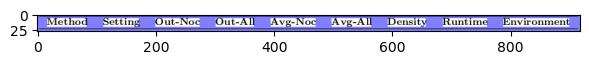

In [66]:
img_ready = prep_image(img)
with torch.no_grad():
    r_pred, c_pred = model(img_ready)
    
r_pred, c_pred = process_split_results(r_pred, c_pred)
r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)
vis_split(img, r_pred, c_pred)

In [67]:
row_borders, col_borders = borders(r_pred), borders(c_pred)
R_pred, D_pred = create_pred_matrices(row_borders, col_borders)
cells_pred = get_cells(row_borders, col_borders)
rule1(cells_pred, chunk_labels[img_name], R_pred, D_pred, verbose=True)
rule2(cells_pred, chunk_labels[img_name], R_pred, D_pred, verbose=True)
cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred, verbose=True)

In [68]:
row_borders_gt, col_borders_gt = borders(r_gt), borders(c_gt)
cells_gt = get_cells(row_borders_gt, col_borders_gt)
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=True)

In [69]:
eval(cells_merged_pred, cells_merged_gt)

(1.0, 1.0, 1.0)

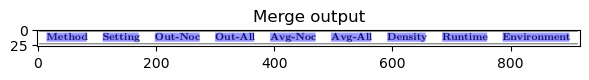

In [70]:
img_mgr = img.copy()

for cell in cells_merged_pred:
    (t, l), (b, r_pred) = cell.pos
    cv.rectangle(img_mgr, (l, t), (r_pred, b), (0, 0, 255), -1)
res = cv.addWeighted(img_mgr, 0.4, img, 0.6, 0)

view_imgs([res], ['Merge output'])

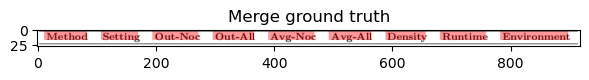

In [71]:
img_mgr = img.copy()

for cell in cells_merged_gt:
    (t, l), (b, r_pred) = cell.pos
    cv.rectangle(img_mgr, (l, t), (r_pred, b), (255,0,0), -1)
res = cv.addWeighted(img_mgr, 0.4, img, 0.6, 0)

view_imgs([res], ['Merge ground truth'])

In [72]:
def eval_process(model, img, img_name, merge_labels, chunk_labels, iou_th=0.6, refine_split=False):
    # PREDICTION
    model.eval()
    img_ready = prep_image(img)
    with torch.no_grad():
        r_pred, c_pred = model(img_ready)
    r_pred, c_pred = process_split_results(r_pred, c_pred)
    if refine_split:
        r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)

    row_borders, col_borders = borders(r_pred), borders(c_pred)
    R_pred, D_pred = create_pred_matrices(row_borders, col_borders)
    cells_pred = get_cells(row_borders, col_borders)
    rule1(cells_pred, chunk_labels[img_name], R_pred, D_pred)
    rule2(cells_pred, chunk_labels[img_name], R_pred, D_pred)
    cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred)

    # GROUND TRUTH
    r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
    row_borders_gt, col_borders_gt = borders(r_gt), borders(c_gt)
    cells_gt = get_cells(row_borders_gt, col_borders_gt)
    cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt)

    return eval(cells_merged_pred, cells_merged_gt, threshold=iou_th)

eval_process(model, img, img_name, merge_labels, chunk_labels, iou_th=0.7, refine_split=True)

(0.0, 0.0, 0.0)

**Observation:** IoU might not be the best metrics as results can change drastically when IoU threshold changes from 0.7 to 0.6

In [73]:
for img, img_name in zip(single_row_col_imgs, single_row_col_img_names):
    if img_name == '1705.09436v1.1': 
        continue
    print(eval_process(model, img, img_name, merge_labels, chunk_labels, iou_th=0.7, refine_split=True))

(0.7777777777777778, 0.7777777777777778, 0.7777777777777778)
(0.0, 0.0, 0.0)
(0.6363636363636364, 0.6363636363636364, 0.6363636363636364)
(0.23076923076923075, 0.25, 0.21428571428571427)
(0.3076923076923077, 0.4, 0.25)
(0.24000000000000002, 0.25, 0.23076923076923078)
(0.4615384615384615, 0.5454545454545454, 0.4)


## `Case 2:` Shape mismatch

In [74]:
shape_mismatch_names = load_json(os.path.join(TRAIN_ERROR_DIR, 'shape_mismatch.json'))
len(shape_mismatch_names)

1057

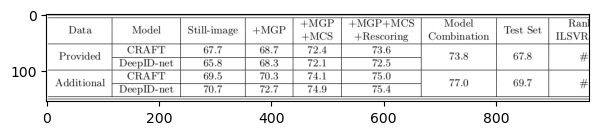

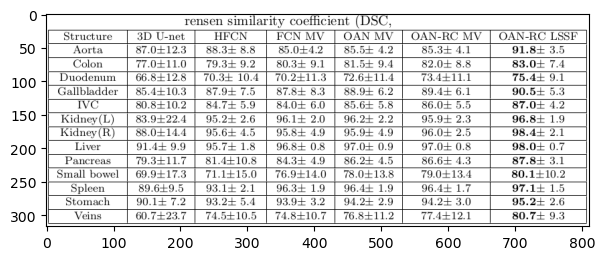

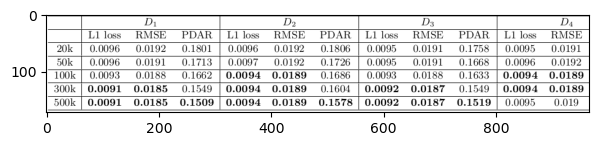

In [76]:
shape_mismatch_paths = [os.path.join(IMG_DIR, img_name + '.png') for img_name in shape_mismatch_names]
shape_mismatch_imgs = [load_image(img_path) for img_path in shape_mismatch_paths]
for img in shape_mismatch_imgs[:3]:
    view_imgs([img])

Path: /Users/longhoang/Developer/table-reg/data/scitsr-split-train/train/img/1804.08414v1.1.png


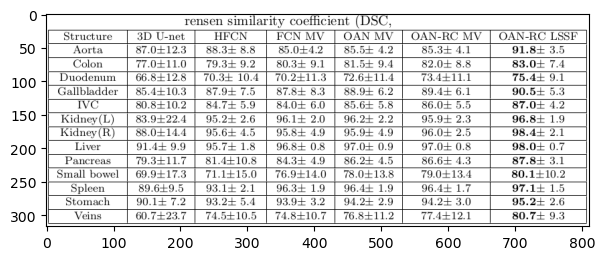

In [81]:
ID = 1
img, path, img_name = shape_mismatch_imgs[ID], shape_mismatch_paths[ID], shape_mismatch_names[ID]
print('Path:', path)
view_imgs([img])

In [82]:
r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
print('* Split ground truth:')
print(f'  Row vector of shape {r_gt.shape}, Col vector of shape {c_gt.shape}')
print('* Merge ground truth:')
print(f'  Merge right matrix of shape {R_gt.shape}, Merge down matrix of shape {D_gt.shape}')

* Split ground truth:
  Row vector of shape (317,), Col vector of shape (811,)
* Merge ground truth:
  Merge right matrix of shape (14, 6), Merge down matrix of shape (13, 7)


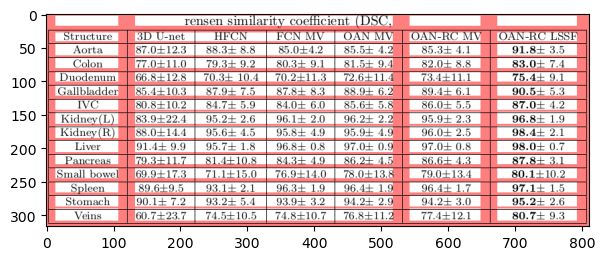

In [83]:
vis_split(img, r_gt, c_gt, 'red')

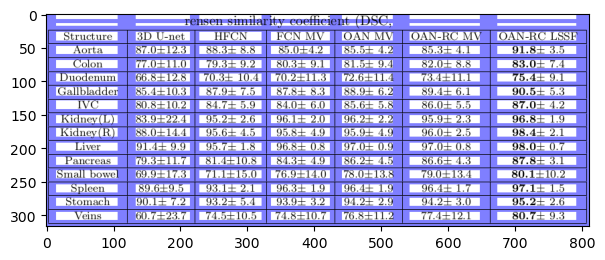

In [84]:
img_ready = prep_image(img)
with torch.no_grad():
    r_pred, c_pred = model(img_ready)
    
r_pred, c_pred = process_split_results(r_pred, c_pred)
r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)
vis_split(img, r_pred, c_pred)

In [91]:
row_borders, col_borders = borders(r_pred), borders(c_pred)
print(f'Prediction -- num. rows: {len(row_borders) // 2}, num. cols: {len(col_borders) // 2}\n')
R_pred, D_pred = create_pred_matrices(row_borders, col_borders)
cells_pred = get_cells(row_borders, col_borders)
rule1(cells_pred, chunk_labels[img_name], R_pred, D_pred, verbose=True)
rule2(cells_pred, chunk_labels[img_name], R_pred, D_pred, verbose=True)
cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred, verbose=True)

Prediction -- num. rows: 16, num. cols: 7

Merge right at cell (0,1)
Merge down at cell (0,1)
Merge right at cell (0,2)
Merge right at cell (0,3)
Merge down at cell (0,4)
Merge right at cell (0,4)
Merge right at cell (0,1)
Merge right at cell (0,3)


In [93]:
row_borders_gt, col_borders_gt = borders(r_gt), borders(c_gt)
print(f'Ground truth -- num. rows: {len(row_borders_gt) // 2}, num. cols: {len(col_borders_gt) // 2}\n')
cells_gt = get_cells(row_borders_gt, col_borders_gt)
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=True)

Ground truth -- num. rows: 15, num. cols: 4



AssertionError: Shape of R and D don't match the number of cells